## Food Order Analysis Using Python

I started with the task of importing the necessary library and the dataset

In [29]:
import pandas as pd
data = pd.read_csv('/content/food_orders_new_delhi.csv')
df = data.copy()
df.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


I checked the information about the dataset and I realized that there are null values

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


I decided to replace all categorical columns with their mode and all numerical columns with their median in order to balance the dataset

In [31]:
for i in df.columns:
    if (df[i].isnull().sum() / len(df)) * 100 > 30:
        df.drop(i, axis = 1, inplace = True)
    elif df[i].dtypes == 'O':
        df[i].fillna(df[i].mode()[0], inplace = True)

    elif df[i].dtypes != 'O':
        df[i].fillna(df[i].median(), inplace = True)

df.isnull().sum()

<ipython-input-31-de67dc8e6d42>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].fillna(df[i].median(), inplace = True)
<ipython-input-31-de67dc8e6d42>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

,0
Order ID,0
Customer ID,0
Restaurant ID,0
Order Date and Time,0
Delivery Date and Time,0
Order Value,0
Delivery Fee,0
Payment Method,0
Discounts and Offers,0
Commission Fee,0


I decided to convert the 'Order Date abd Time' and 'Delivery Date and Time' to a datetime format

In [32]:
from datetime import datetime

# convert date and time columns to datetime
df['Order Date and Time'] = pd.to_datetime(df['Order Date and Time'])
df['Delivery Date and Time'] = pd.to_datetime(df['Delivery Date and Time'])


I started the data preparation and I created a new column for discount amount where I extracted the percentage discounts and apply them to the order value

In [33]:
def extract_discount(discount_str):

    if 'off' in discount_str:
        return float(discount_str.split(' ')[0])
    elif '%' in discount_str:
        return float(discount_str.split('%')[0])
    else:
        return 0.0

df['Discount Percentage'] = df['Discounts and Offers'].apply(lambda x: extract_discount(x))

df['Discount Amount'] = df.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if x['Discount Percentage'] > 1
                                                   else x['Discount Percentage'], axis=1)

df['Discount Amount'] = df.apply(lambda x: x['Discount Amount'] if x['Discount Percentage'] <= 1
                                                   else x['Order Value'] * x['Discount Percentage'] / 100, axis=1)

print(df[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head(), df.dtypes)

   Order Value Discounts and Offers  Discount Percentage  Discount Amount
0         1914            5% on App                  5.0            95.70
1          986                  10%                 10.0            98.60
2          937         15% New User                 15.0           140.55
3         1463                  10%                 10.0           146.30
4         1992         50 off Promo                 50.0           996.00 Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time       datetime64[ns]
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
Discount Percentage              float64
Discount Amount        

I did the cost and profit analysis by aggregating the data in order to get the overall metrics

In [34]:
df['Total Costs'] = df['Delivery Fee'] + df['Payment Processing Fee'] + df['Discount Amount']
df['Revenue'] = df['Commission Fee']
df['Profit'] = df['Revenue'] - df['Total Costs']

total_orders = df.shape[0]
total_revenue = df['Revenue'].sum()
total_costs = df['Total Costs'].sum()
total_profit = df['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}

print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': np.int64(126990), 'Total Costs': np.float64(252095.55), 'Total Profit': np.float64(-125105.55)}


I imported the necessary libraries I will be needing for the data visualizations

In [35]:
import plotly.express as pe
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as pg

I did some visualization for an histplot showing their distributions

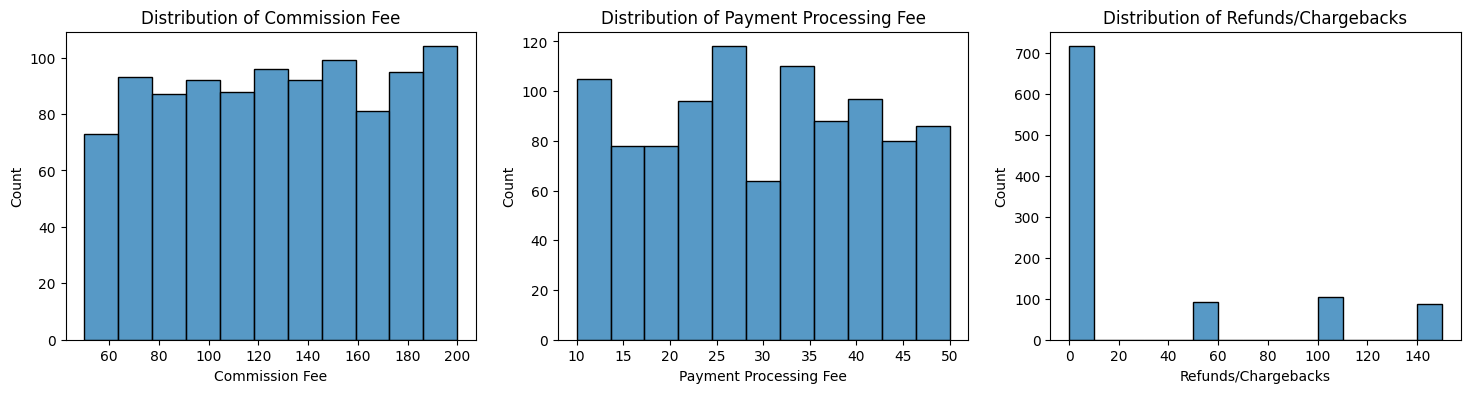

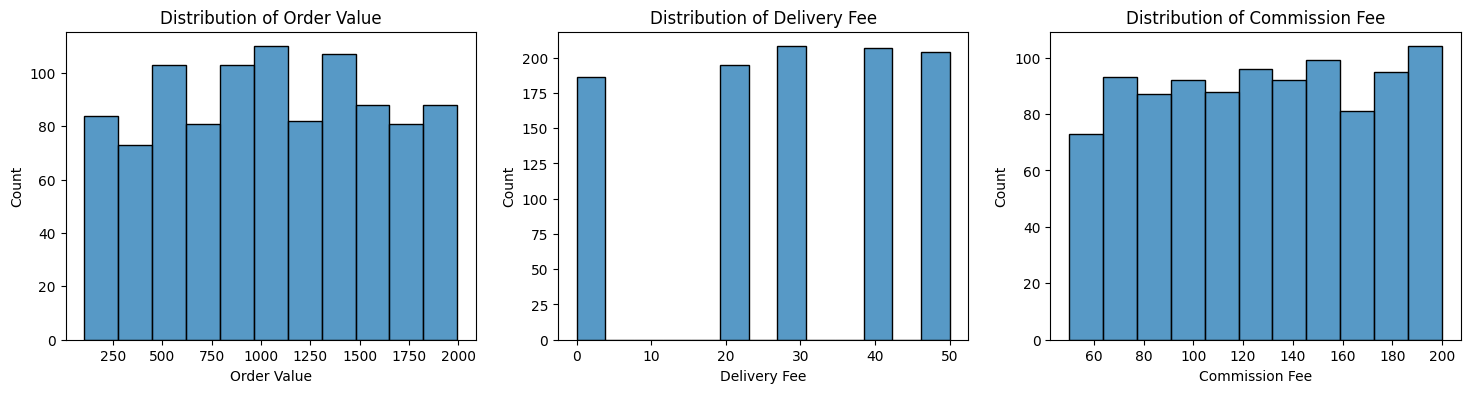

In [37]:
def plotter(dataframe, a, b, c):
  plt.figure(figsize = (18,4))
  plt.subplot(1,3,1)
  sns.histplot(x=dataframe[a])
  plt.title(f'Distribution of {a}')

  plt.subplot(1,3,2)
  sns.histplot(x = dataframe[b])
  plt.title(f'Distribution of {b}')

  plt.subplot(1,3,3)
  sns.histplot(x = dataframe[c])
  plt.title(f'Distribution of {c}')

  plt.show()

plotter(data, 'Commission Fee', 'Payment Processing Fee', 'Refunds/Chargebacks')
plotter(data, 'Order Value', 'Delivery Fee', 'Commission Fee')

I also used the bar chart

In [42]:
select = data[['Payment Method', 'Commission Fee']]
select = select.groupby('Payment Method')[['Commission Fee']].mean().sort_values(by = 'Commission Fee', ascending = False)
select

fig = pe.bar(data_frame= select, x = select.index, y= 'Commission Fee', color = 'Commission Fee', width = 700, height=500, title='Distrbution of  Payment Method')
fig.show()

In [43]:
select = data[['Payment Method', 'Refunds/Chargebacks']]
select = select.groupby('Payment Method')[['Refunds/Chargebacks']].mean().sort_values(by = 'Refunds/Chargebacks', ascending = False)
select

fig = pe.bar(data_frame= select, x = select.index, y= 'Refunds/Chargebacks', color = 'Refunds/Chargebacks', width = 700, height=500, title='Distrbution of  Payment Method')
fig.show()

I viualized using an histogram to viualize the profitable and unprofitable orders

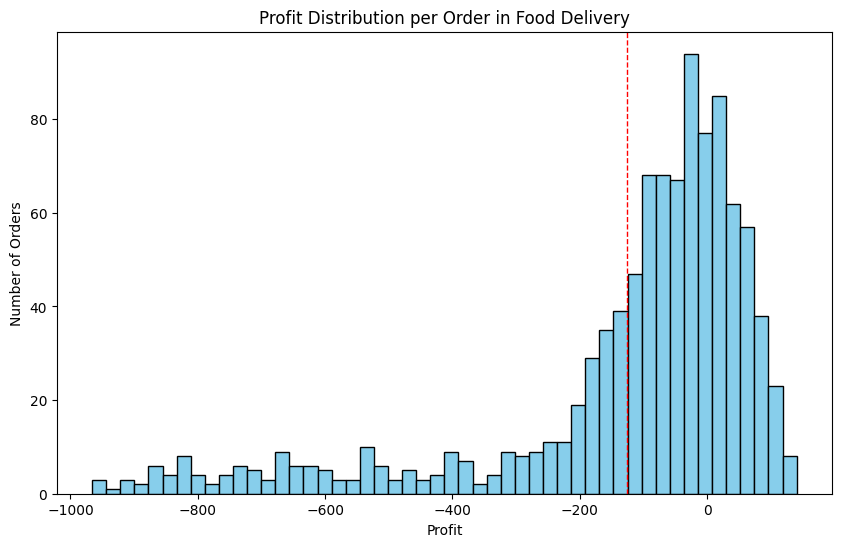

In [38]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.hist(df['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(df['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

I made a piechart to viualize the proportion of the total cost

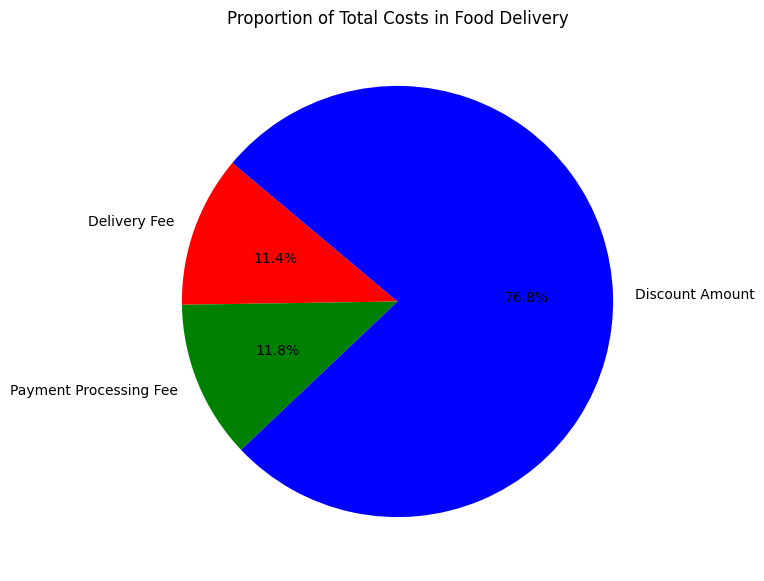

In [44]:
select = df[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7, 7))
plt.pie(select, labels=select.index, autopct='%1.1f%%', startangle=140, colors=['red', 'green', 'blue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

I ended it with a bar chart to compare the total revenue,total costs and total profit

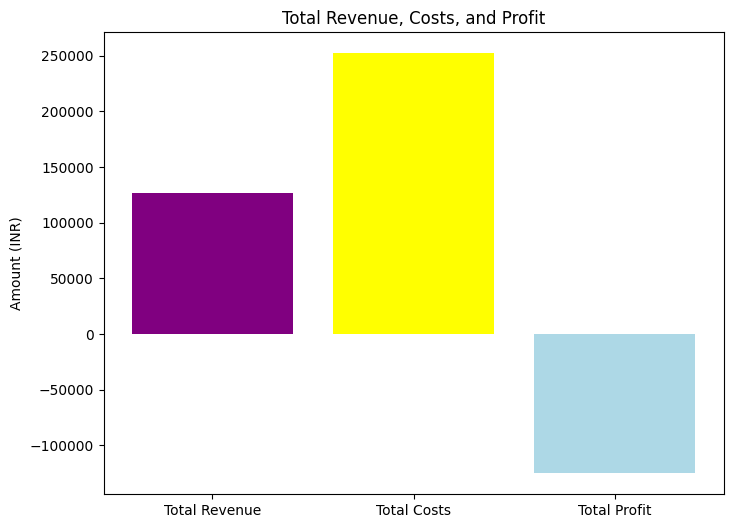

In [48]:
totals = ['Total Revenue', 'Total Costs', 'Total Profit']
values = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8, 6))
plt.bar(totals, values, color=['purple', 'yellow', 'lightblue'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount (INR)')
plt.show()